# <span style="color:blue">Desafío 4- Clasificación de calidad de ramen</span>

### <span style="color:orange">Importación de librerías - Cargar la data</span>

In [171]:
# Suprimir advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Librerías básicas para análisis de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y herramientas de Machine Learning
from sklearn.datasets import make_blobs, make_circles
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


# Cargar los datos 
ramen_data = pd.read_excel(r"C:\Users\atapi\Documents\DATA SCIENCE\Modulo 5-ML\aprendizaje no supervisado III\desafio\ramen-ratings.xlsx")
ramen_data.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


### <span style="color:orange">Análisis Exploratorio de Datos</span>

- El dataset contiene las siguientes columnas:

    - **Review #:** Número de revisión.
    - **Brand:** Marca del ramen.
    - **Variety:** Variedad del producto.
    - **Style:** Estilo del paquete, "Cup" o "Pack".
    - **Country:** País de origen.
    - **Stars:** Calificación en estrellas.
    - **Top Ten:** Posición en el Top Ten.


- El siguiente paso será desarrollar una función que:

    - Identifique y trate valores nulos.
    - Elimine columnas irrelevantes.
    - Maneje valores atípicos en las columnas numéricas.
    - Prepare el conjunto de datos para futuros análisis.

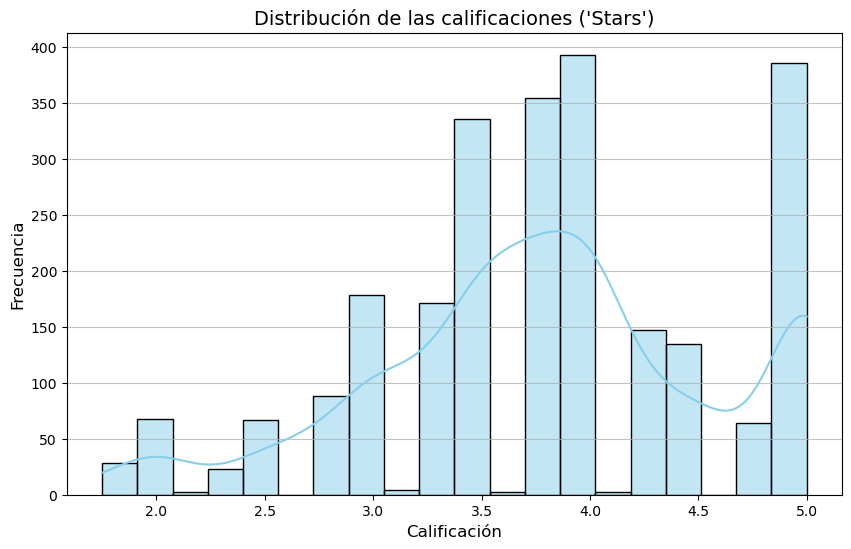

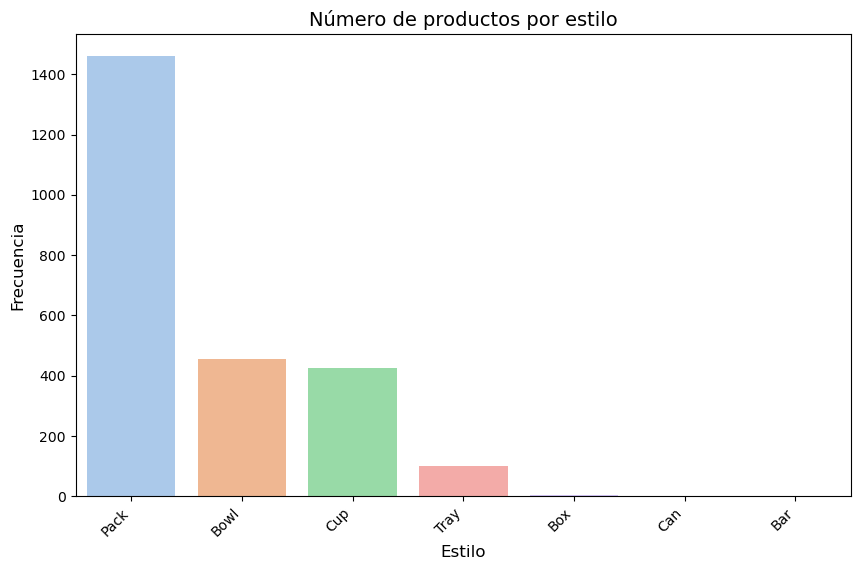

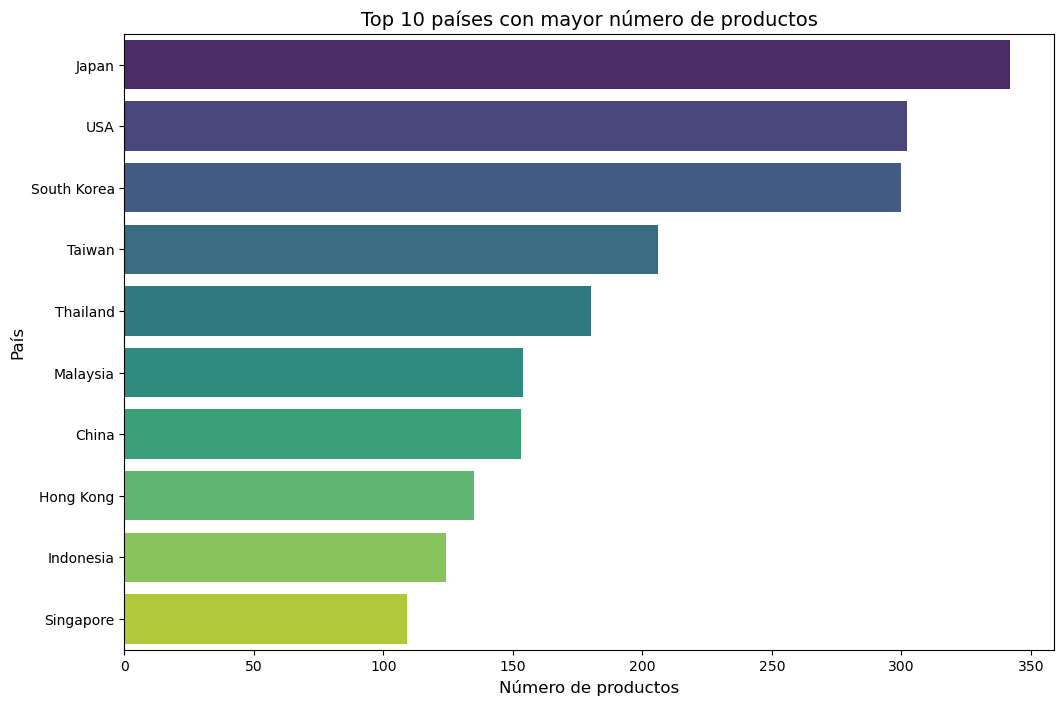

In [173]:
def analizar_y_limpiar_data(df):
    """
    Análisis y limpieza de datos con gráficos explicativos:
    - Identifica y elimina valores nulos.
    - Elimina columnas irrelevantes.
    - Maneja valores atípicos en columnas numéricas.
    - Incluye gráficos de distribución de calificaciones, estilo y países.
    - No rellena valores nulos; los elimina directamente.
    - Devuelve un dataframe limpio.

    :parámetro df: DataFrame original.
    :return: DataFrame limpio.
    """
    # Crear una copia del DataFrame para evitar modificar el original
    # Esto asegura que el DataFrame proporcionado no se altere durante el proceso
    clean_df = df.copy()
    
    # Convertir la columna 'Stars' a formato numérico
    # 'errors="coerce"' convierte valores no numéricos a NaN para poder eliminarlos después
    clean_df['Stars'] = pd.to_numeric(clean_df['Stars'], errors='coerce')
    
    # Eliminar filas con valores nulos en columnas clave ('Brand', 'Variety', 'Stars')
    # Estas columnas son esenciales para el análisis, por lo que las filas incompletas no se conservan
    clean_df.dropna(subset=['Brand', 'Variety', 'Stars'], inplace=True)
    
    # Eliminar columnas que no son relevantes para el análisis
    # Por ejemplo: 'Review #' (un identificador) y 'Top Ten' (demasiado específico o con muchos nulos)
    columns_to_drop = ['Review #', 'Top Ten']
    clean_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    # Detectar y manejar valores atípicos en la columna numérica 'Stars'
    # Se usa el rango intercuartil (IQR) para identificar valores fuera de un rango razonable
    Q1 = clean_df['Stars'].quantile(0.25)  # Primer cuartil (25%)
    Q3 = clean_df['Stars'].quantile(0.75)  # Tercer cuartil (75%)
    IQR = Q3 - Q1  # Rango intercuartil
    lower_bound = Q1 - 1.5 * IQR  # Límite inferior
    upper_bound = Q3 + 1.5 * IQR  # Límite superior
    # Mantener solo las filas cuyos valores estén dentro de los límites calculados
    clean_df = clean_df[(clean_df['Stars'] >= lower_bound) & (clean_df['Stars'] <= upper_bound)]
    
    # Resetear los índices del DataFrame después de eliminar filas
    clean_df.reset_index(drop=True, inplace=True)
    
    # Visualizar la distribución de calificaciones (Stars)
    # Se usa un histograma para entender cómo están distribuidas las calificaciones
    plt.figure(figsize=(10, 6))
    sns.histplot(clean_df['Stars'], bins=20, kde=True, color='skyblue')  # kde=True agrega una línea de densidad
    plt.title("Distribución de las calificaciones ('Stars')", fontsize=14)
    plt.xlabel("Calificación", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.grid(axis='y', alpha=0.75)  # Agregar una cuadrícula horizontal para facilitar la lectura
    plt.show()
    
    # Visualizar cantidad de productos por estilo (Style)
    # Un gráfico de barras muestra cuántos productos hay por cada tipo de presentación (por ejemplo: Cup, Pack,etc.)
    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=clean_df, 
        x='Style', 
        order=clean_df['Style'].value_counts().index,  # Ordenar por frecuencia descendente
        palette='pastel'
    )
    plt.title("Número de productos por estilo", fontsize=14)
    plt.xlabel("Estilo", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas para evitar superposición
    plt.show()
    
    # Visualizar cantidad de productos por país (Country)
    # Mostrar solo los 10 países con más productos mediante un gráfico de barras horizontales
    plt.figure(figsize=(12, 8))
    top_countries = clean_df['Country'].value_counts().nlargest(10)  # Seleccionar los 10 países principales
    sns.barplot(
        y=top_countries.index,  # Países en el eje Y
        x=top_countries.values,  # Cantidades en el eje X
        palette='viridis'  # Colores para mejor visualización
    )
    plt.title("Top 10 países con mayor número de productos", fontsize=14)
    plt.xlabel("Número de productos", fontsize=12)
    plt.ylabel("País", fontsize=12)
    plt.show()
    
    # Retornar el DataFrame limpio para su uso posterior
    return clean_df

# Aplicar la función al dataset cargado y limpiar los datos
limpieza_ramen_data = analizar_y_limpiar_data(ramen_data)


**Explicación de la función analizar_y_limpiar_data** 

- **Conversión y eliminación de valores nulos:**

    - La columna Stars se convierte a formato numérico para evitar problemas de formato.
    - Se eliminan las filas con valores nulos en columnas esenciales como Brand, Variety y Stars.
    - Eliminación de columnas irrelevantes: Columnas como Review # y Top Ten se eliminan por ser innecesarias.

- **Tratamiento de valores atípicos:** En la columna Stars, se detectan y eliminan valores extremos utilizando el rango intercuartil (IQR).

- **Generación de gráficos:**

    - **Distribución de calificaciones (Stars):** Histograma que muestra la distribución de las calificaciones después de limpiar los datos.
    - **Número de productos por estilo (Style):** Gráfico de barras para visualizar la frecuencia de cada estilo de ramen (por ejemplo, "Cup", "Pack").
    - **Top 10 países con mayor número de productos (Country):** Gráfico de barras horizontal con los 10 países con más productos en el dataset.

**<span style="color:olive">Expliación de los gráficos</span>**

- **Gráfico 1: Distribución de las calificaciones (Stars)**
    - Este histograma muestra cómo están distribuidas las calificaciones de los productos de ramen.
    - Se observa que las calificaciones más comunes están entre 3.5 y 5.0, indicando que una mayoría de los productos son considerados de calidad media a alta.
    - La curva de densidad indica que hay una tendencia hacia calificaciones altas, pero también existen productos con calificaciones bajas (< 3.0).

- **Gráfico 2: Número de productos por tipo de presentación**
    - Este gráfico de barras presenta la cantidad de productos según su estilo de empaque o presentación.
    - "Pack" es el estilo predominante con una cantidad significativamente mayor que el resto.
    - Estilos como "Bowl" y "Cup" son populares, pero mucho menos frecuentes en comparación con "Pack".
    - Otros estilos, como "Tray", "Box", "Can", y "Bar", tienen una representación mucho menor.

- **Gráfico 3: Top 10 países con mayor número de productos**

    - Este gráfico de barras horizontales destaca los 10 países con más productos en el dataset.
    - Japón lidera con la mayor cantidad de productos de ramen, seguido por Estados Unidos y Corea del Sur.
    - Países como Taiwán, Tailandia, y Malasia también tienen una representación notable, mientras que países como Indonesia y Singapur ocupan los últimos lugares del Top 10.


### <span style="color:orange">Procesamiento de los datos</span>

Vamos a realizar el preprocesamiento de los datos según el segundo punto:

- **Normalización de características numéricas**
    - Escala las características numéricas para que sus valores estén entre 0 y 1.
    - Decidiremos cuál usar en función de los datos disponibles. En este caso, la columna Stars es la única numérica que necesitamos procesar.

- **Codificación de variables categóricas**
    - Usaremos One-Hot Encoding para convertir columnas categóricas como Style y Country en variables numéricas.

- **División de los datos**
    - Dividiremos el dataset en conjunto de entrenamiento (80%) y conjunto de prueba (20%).
 
**<span style="color:olive">Expliación de la función</span>**

- **Separación de características (X) y etiqueta objetivo (y):**

    - X contiene todas las columnas necesarias para hacer predicciones.
    - y contiene la columna que será predicha por el modelo (Stars).


- **Transformación de columnas categóricas:**

    - **OneHotEncoder** convierte las categorías en representaciones binarias.
    - **ColumnTransformer** aplica esta transformación solo a columnas categóricas, dejando pasar las columnas numéricas sin cambios.


- **Pipeline:** El pipeline asegura que las transformaciones son aplicadas consistentemente, permitiendo aplicar las transformaciones de manera eficiente.


- **División de los datos:**

    - train_test_split divide el dataset en entrenamiento (80%) y prueba (20%) para evaluar el modelo con datos no vistos.

- **Tamaños de los conjuntos:** Se imprimen para verificar que la división fue correcta.


In [175]:
def preprocesar_datos(df):
    """
    Preprocesamiento de datos para Machine Learning:
    - Codifica las variables categóricas utilizando OneHotEncoder.
    - Divide los datos en conjuntos de entrenamiento y prueba.
    
    Args:
        df (pd.DataFrame): Dataset limpio.
    
    Returns:
        X_train, X_test, y_train, y_test: Conjuntos de entrenamiento y prueba.
    """
    # Separar las características (X) y la etiqueta objetivo (y)
    # La etiqueta objetivo ('Stars') se separa para ser predicha por los modelos
    X = df.drop(columns=['Stars'])  # Características: todas las columnas excepto 'Stars'
    y = df['Stars']                # Etiqueta objetivo: columna 'Stars'
    
    # Identificar las columnas categóricas
    # Estas columnas contienen valores no numéricos y deben transformarse para ser usadas en el modelo
    categorical_features = ['Brand', 'Variety', 'Style', 'Country']
    
    # Crear un transformador para las columnas categóricas usando OneHotEncoder
    # OneHotEncoder convierte cada categoría en una representación binaria (0 o 1)
    # 'handle_unknown="ignore"' asegura que no se produzcan errores si hay categorías desconocidas en los datos nuevos
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Combinar las transformaciones usando ColumnTransformer
    # Esto permite aplicar OneHotEncoder solo a las columnas categóricas, dejando otras columnas intactas
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features)  # Aplicar OneHotEncoder a columnas categóricas
        ],
        remainder='passthrough'  # Dejar pasar columnas numéricas sin cambios
    )
    
    # Crear un pipeline para preprocesar los datos
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)  # Agregar el preprocesador definido anteriormente
    ])
    
    # Aplicar el pipeline a las características (X)
    # El resultado es una matriz transformada lista para ser usada en el modelo 
    X_preprocessed = pipeline.fit_transform(X)
    
    # Dividir el dataset en conjuntos de entrenamiento y prueba
    # Esto se hace para evaluar el desempeño del modelo con datos no vistos durante el entrenamiento
    # test_size=0.2 indica que el 20% de los datos se reservarán para pruebas
    # random_state=42 asegura que la división sea reproducible
    X_train, X_test, y_train, y_test = train_test_split(
        X_preprocessed, y, test_size=0.2, random_state=42)
    
    # Retornar los conjuntos generados para entrenamiento y prueba
    return X_train, X_test, y_train, y_test

# Aplicar el preprocesamiento al dataset limpio
X_train, X_test, y_train, y_test = preprocesar_datos(limpieza_ramen_data)

# Verificar tamaños de los conjuntos generados
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)



Tamaño del conjunto de entrenamiento: (1958, 2664)
Tamaño del conjunto de prueba: (490, 2664)
Tamaño de y_train: (1958,)
Tamaño de y_test: (490,)


**<span style="color:olive">Detalles del resultado:</span>**

- **Tamaño del conjunto de entrenamiento (X_train):**

    - **1958 filas:** Son las muestras utilizadas para entrenar el modelo (80% del dataset total).
    - **2664 columnas:** Corresponden a las características después de aplicar One-Hot Encoding. Esto incluye las combinaciones únicas de las variables categóricas (Brand, Variety, Style, Country).

- **Tamaño del conjunto de prueba (X_test):**

    - **490 filas:** Son las muestras reservadas para evaluar el modelo (20% del dataset total).
    - **2664 columnas:** Se mantienen las mismas características codificadas del conjunto de entrenamiento.

- **Tamaño de las etiquetas (y_train y y_test): y_train: (1958,) y y_test: (490,):**

    - Estos arrays contienen las calificaciones (Stars) asociadas a cada muestra de los conjuntos de entrenamiento y prueba.
    - El tamaño corresponde al número de filas en X_train y X_test.


**Balance en la división:**

- El dataset se dividió correctamente en 80% para entrenamiento y 20% para prueba.
- Esto asegura que el modelo tenga suficientes datos para aprender y evaluar en un conjunto independiente.
.

### **<span style="color:purple">Verificar balanceo de clases</span>**

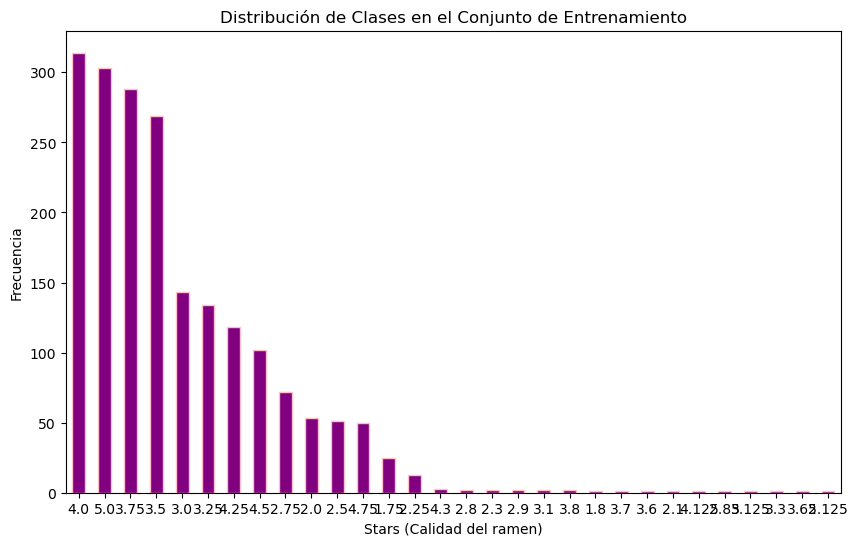

In [178]:
# Visualización de la distribución de clases en el conjunto de entrenamiento
# Crear un gráfico de barras para la distribución de las clases
plt.figure(figsize=(10, 6))
class_counts = y_train.value_counts()
class_counts.plot(kind='bar', color='purple', edgecolor='pink')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('Stars (Calidad del ramen)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)


plt.show()



- **Distribución de Clases en el Conjunto de Entrenamiento:** El gráfico muestra la distribución de las calificaciones de calidad del ramen (Stars) en el conjunto de entrenamiento. Cada barra representa una clase específica.

- **Observaciones:**

1. **Desbalance en las clases:**
   
    - Las calificaciones más altas (por ejemplo, 4.0, 5.0 y 3.75) son significativamente más frecuentes en comparación con las más bajas (por ejemplo, 1.8, 2.3). Esto sugiere que el dataset está desbalanceado, lo que podría influir en el rendimiento de los modelos al favorecer las clases mayoritarias.

2. **Frecuencia decreciente:**

    - Existe una tendencia general a tener menos datos en las clases a medida que las calificaciones se alejan de los valores centrales.

- **Conclusión**: Es necesario aplicar técnicas de balanceo para evitar que el modelo se sesgue hacia las clases más frecuentes. Para ello se implementará la técnica de balanceo como SMOTE o submuestreo para equilibrar las clases y garantizar que el modelo pueda aprender de todas las categorías de calificaciones de manera uniforme.

In [180]:
from imblearn.over_sampling import SMOTE

# Convertir la columna objetivo (y_train) en categórica: 1 (Bueno) y 0 (Malo) según un umbral de 3.5
y_train_categorical = (y_train >= 3.5).astype(int)  # 1: Bueno, 0: Malo

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_categorical)

# Verificar la nueva distribución de las clases
distribucion_clase_balanceada = pd.Series(y_train_balanced).value_counts()
print("Distribución de las clases después de aplicar SMOTE:\n")
print(distribucion_clase_balanceada)


Distribución de las clases después de aplicar SMOTE:

Stars
1    1453
0    1453
Name: count, dtype: int64


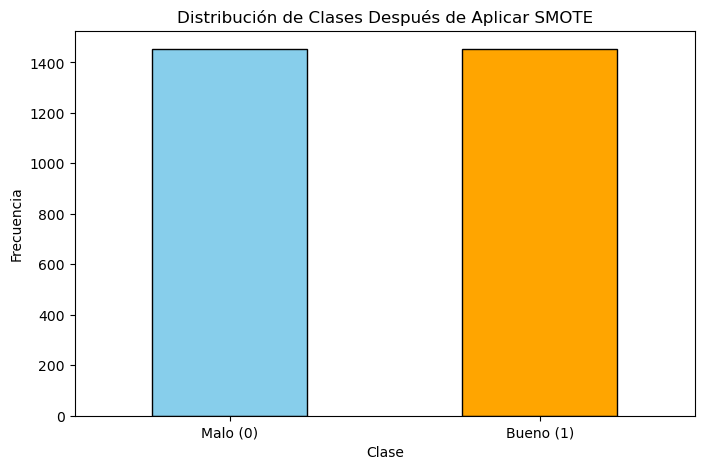

In [181]:
# Gráfico de barras para la distribución balanceada
plt.figure(figsize=(8, 5))
distribucion_clase_balanceada.plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')
plt.title('Distribución de Clases Después de Aplicar SMOTE')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1], labels=['Malo (0)', 'Bueno (1)'], rotation=0)
plt.show()


**<span style="color:purple">Análisis de la distribución de clases después de aplicar SMOTE</span>**

El gráfico presentado muestra la distribución de clases después de aplicar la técnica SMOTE (Synthetic Minority Oversampling Technique) para balancear el conjunto de entrenamiento.

- **Descripción de las clases:**
    - **Clase 0 (Malo):** Representa los productos de ramen con calificaciones por debajo del umbral establecido (3.5).
    - **Clase 1 (Bueno):** Representa los productos de ramen con calificaciones iguales o superiores al umbral.


- **Distribución balanceada:** Después de aplicar SMOTE, ambas clases tienen exactamente la misma cantidad de observaciones: 1453 muestras. Esto elimina el problema de desbalance original, donde la clase "Bueno" era mayoritaria.

Con este balance, los modelos que se realizarán posteriormente tendrán una representación equitativa de ambas clases durante el entrenamiento. Con esto se reduce el riesgo de que el modelo se sesgue hacia la clase mayoritaria y mejora su capacidad para identificar correctamente ambas categorías.


- **Gráfico:** Las barras del gráfico muestran claramente que las clases "Malo (0)" y "Bueno (1)" están ahora igualmente representadas, gracias a la generación de muestras sintéticas para la clase minoritaria.


- **Conclusión:** Usar SMOTE ha sido exitoso para balancear las clases del conjunto de entrenamiento. Este es un paso importante para garantizar que el modelo sea justo y efectivo al predecir ambas clases, especialmente en problemas donde una clase tenía inicialmente una representación mucho menor. Esto debería reflejarse en métricas más equilibradas, como precisión, recall y F1-score, al evaluar el modelo.


### <span style="color:orange">Implementar modelos de clasificación</span>

**Pasos:**

- Entrenar modelos de clasificación:
    - Regresión Logística
    - Support Vector Machine (SVM)


In [184]:
# Escalar las características del conjunto de datos utilizando StandardScaler
# - StandardScaler: Normaliza los datos para que tengan media 0 y desviación estándar 1.
# - with_mean=False: Necesario porque los datos están en formato de matriz dispersa (sparse matrix).
#   Esto evita errores al intentar centrar las matrices dispersas.
scaler = StandardScaler(with_mean=False)

# Aplicar el escalado al conjunto de entrenamiento
# - fit_transform: Ajusta el escalador al conjunto de entrenamiento y lo transforma.
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar el escalador ajustado al conjunto de prueba
# - transform: Utiliza los parámetros del escalador ajustado en los datos de entrenamiento para transformar el conjunto de prueba.
X_test_scaled = scaler.transform(X_test)

# Definir un rango de valores para los hiperparámetros de Regresión Logística
# - 'C': Parámetro de regularización. Valores más pequeños indican mayor regularización.
# - 'solver': Algoritmo de optimización para ajustar el modelo.
#   - 'liblinear': Recomendado para problemas pequeños o regulares.
#   - 'lbfgs': Más eficiente para problemas grandes.
param_grid_lr = {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}

# Usar GridSearchCV para buscar los mejores hiperparámetros de Regresión Logística
# - LogisticRegression(): Modelo de Regresión Logística.
# - max_iter=1000: Número máximo de iteraciones para asegurar la convergencia del modelo.
# - random_state=42: Fija la semilla aleatoria para reproducibilidad.
# - cv=5: Realiza validación cruzada con 5 particiones del conjunto de entrenamiento.
# - scoring='accuracy': Usa la precisión como métrica de evaluación.
grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42), 
    param_grid_lr, 
    cv=5, 
    scoring='accuracy'
)

# Entrenar el modelo de Regresión Logística usando los datos balanceados
# - fit: Encuentra los mejores hiperparámetros y ajusta el modelo en el conjunto balanceado.
grid_search_lr.fit(X_train_balanced, y_train_balanced)

# Obtener el mejor modelo después de la búsqueda de hiperparámetros
# - best_estimator_: Devuelve el modelo con los hiperparámetros óptimos encontrados por GridSearchCV.
best_lr = grid_search_lr.best_estimator_

#________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________

# Definir un rango de valores para los hiperparámetros de SVM
# - 'C': Parámetro de regularización. Valores más grandes indican menor regularización.
# - 'kernel': Función del núcleo utilizada para proyectar datos a espacios dimensionales más altos.
#   - 'linear': Núcleo lineal para problemas linealmente separables.
#   - 'rbf': Núcleo radial para problemas no lineales complejos.
# - 'gamma': Controla la influencia de los puntos de soporte.
#   - 'scale': Calcula automáticamente basado en el tamaño de los datos.
#   - 'auto': Usa el inverso del número de características.
param_grid_svm = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

# Usar GridSearchCV para buscar los mejores hiperparámetros de SVM
# - SVC(): Clasificador de Máquinas de Vectores de Soporte.
# - cv=5: Valida con 5 particiones para evaluar las combinaciones de hiperparámetros.
grid_search_svm = GridSearchCV(
    SVC(random_state=42), 
    param_grid_svm, 
    cv=5, 
    scoring='accuracy'
)

# Entrenar el modelo SVM con los datos balanceados
# - fit: Ajusta el modelo con el conjunto de entrenamiento balanceado.
grid_search_svm.fit(X_train_balanced, y_train_balanced)

# Obtener el mejor modelo después de la búsqueda de hiperparámetros
# - best_estimator_: Devuelve el modelo ajustado con los hiperparámetros óptimos.
best_svm = grid_search_svm.best_estimator_

# Evaluar el modelo de Regresión Logística en el conjunto de prueba
# - Convertir y_test en etiquetas categóricas:
#   - 1: Calificación "Bueno" (>= 3.5).
#   - 0: Calificación "Malo" (< 3.5).
y_test_categorical = (y_test >= 3.5).astype(int)

# Generar predicciones en el conjunto de prueba usando el mejor modelo de Regresión Logística
# - predict: Predice las etiquetas para los datos de prueba.
y_pred_lr = best_lr.predict(X_test_scaled)

# Evaluar el modelo SVM en el conjunto de prueba
# - predict: Genera predicciones para el conjunto de prueba.
y_pred_svm = best_svm.predict(X_test_scaled)

# Generar y mostrar el reporte de clasificación para Regresión Logística
# - classification_report: Muestra métricas como precisión, recall, F1-score para cada clase.
print("Reporte de clasificación para Regresión Logística:\n")
print(classification_report(y_test_categorical, y_pred_lr))

# Generar y mostrar el reporte de clasificación para SVM
# - Proporciona métricas detalladas para el modelo SVM.
print("\nReporte de clasificación para SVM:\n")
print(classification_report(y_test_categorical, y_pred_svm))



Reporte de clasificación para Regresión Logística:

              precision    recall  f1-score   support

           0       0.42      0.56      0.48       125
           1       0.83      0.74      0.78       365

    accuracy                           0.69       490
   macro avg       0.63      0.65      0.63       490
weighted avg       0.73      0.69      0.70       490


Reporte de clasificación para SVM:

              precision    recall  f1-score   support

           0       0.42      0.55      0.48       125
           1       0.83      0.74      0.78       365

    accuracy                           0.69       490
   macro avg       0.62      0.64      0.63       490
weighted avg       0.72      0.69      0.70       490



#### <span style="color:purple">Resultados de los Modelos: Regresión Logística y SVM</span>

**<span style="color:olive">Análisis de Regresión Logística</span>**

- **Precisión:**
    - Para la clase 0 ("Malo"), la precisión es baja (0.42), lo que significa que el modelo tiene dificultades para identificar correctamente los ejemplos de esta clase.
    - Para la clase 1 ("Bueno"), la precisión es alta (0.83), indicando que la mayoría de las predicciones de esta clase son correctas.

- **Recall:**
    - La clase 0 tiene un recall moderado (0.56), lo que indica que el modelo identifica correctamente el 56% de los ejemplos de esta clase.
    - La clase 1 tiene un recall del 74%, lo que significa que captura la mayoría de los ejemplos positivos.

- **F1-Score:** Equilibrio entre precisión y recall, siendo mejor para la clase 1 (0.78) que para la clase 0 (0.48).

- **Accuracy:** El modelo tiene un Accuracy del 69%, lo que significa que predijo correctamente el 69% de las muestras en el conjunto de prueba.

**<span style="color:olive">Análisis de SVM</span>**

- **Precisión:** Similar al modelo de Regresión Logística, la precisión es baja para la clase 0 (0.42) y alta para la clase 1 (0.83).

- **Recall:** El modelo tiene un recall moderado para la clase 0 (0.55) y alto para la clase 1 (0.74).

- **F1-Score:** El F1-score sigue un patrón similar al modelo de Regresión Logística, con mejores resultados para la clase 1 (0.78) que para la clase 0 (0.48).

- **Accuracy:** También alcanza un 69% de Accuracy, igual al modelo de Regresión Logística.


**<span style="color:green">Comparación de Modelos</span>**

- Ambos modelos tienen un desempeño general similar con una exactitud del 69%.
- La clase 1 ("Bueno") es mejor predicha en ambos modelos, mientras que la clase 0 ("Malo") tiene un rendimiento más pobre.
- La diferencia entre ambos modelos en términos de métricas es mínima, lo que sugiere que su desempeño es comparable para este conjunto de datos.

**<span style="color:purple">Evaluación para la optimización de parámetros</span>**

- **Análisis de los Resultados Actuales**

    - **Exactitud (69%):** Es moderada, por lo que puede ser aceptable dependiendo del contexto. Si el objetivo fuera mejorar esta métrica, podría ser necesario optimizar los hiperparámetros.

    - **Desbalance en las clases:** La clase 0 ("Malo") tiene métricas más bajas (precisión, recall y F1-score). Esto indica que el modelo tiene dificultades para identificar correctamente esta clase. En el caso de que fuera crítico mejorar el desempeño para la clase 0 sería necesario optimizar los hiperparámetros.

    - **Similitud entre modelos:** Ambos modelos tienen resultados muy similares.

- **Conclusión:** Si se decide optimizar parámetros podría ayudar, especialmente si el desempeño de la clase 0 es importante. Sin embargo, los modelos ya están alcanzando un 69% de exactitud, el cual es bastante prudente. Optimizar parámetros sería útil para maximizar el rendimiento.

### <span style="color:orange">Evaluar el rendimiento de los modelos</span>

Para evaluar el rendimiento de ambos modelos (Regresión Logística y SVM) y compararlos, utilizaremos las siguientes métricas:

Precisión (Precision): Proporción de predicciones correctas de una clase específica sobre todas las predicciones realizadas para esa clase.
Recall: Proporción de ejemplos de una clase específica correctamente identificados.
F1-score: Promedio armónico entre precisión y recall, útil para conjuntos desbalanceados.
Área bajo la curva ROC (AUC-ROC): Métrica global que evalúa la capacidad del modelo para distinguir entre las clases.
Pasos:
Calcular las métricas mencionadas para ambos modelos utilizando el conjunto de prueba.
Generar la curva ROC para visualizar el desempeño general.
Comparar los resultados y determinar cuál modelo es más adecuado.

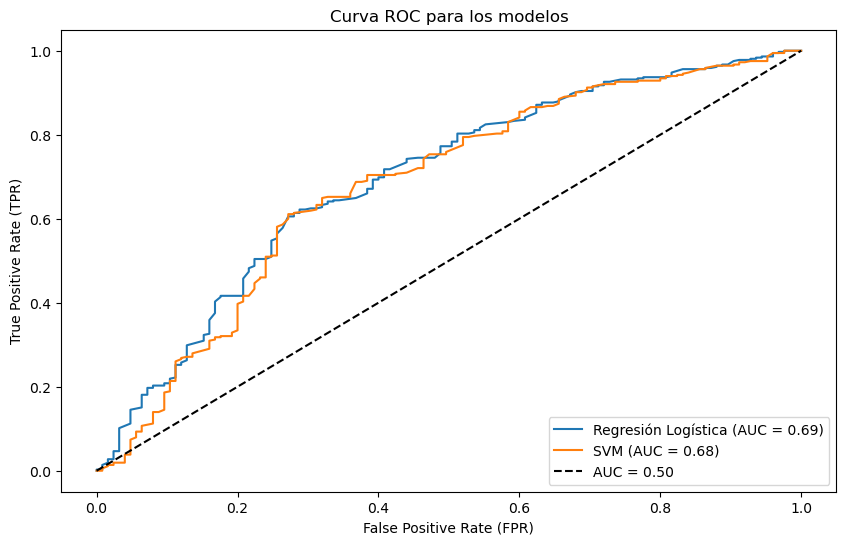

Precisión global (accuracy) y AUC-ROC para cada modelo:

Regresión Logística: Accuracy = 0.69, AUC-ROC = 0.69
SVM: Accuracy = 0.69, AUC-ROC = 0.68


In [188]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

# Calcular probabilidades para la curva ROC
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
y_proba_svm = best_svm.decision_function(X_test)

# Calcular AUC-ROC para ambos modelos
auc_lr = roc_auc_score((y_test >= 3.5).astype(int), y_proba_lr)
auc_svm = roc_auc_score((y_test >= 3.5).astype(int), y_proba_svm)

# Generar curvas ROC
fpr_lr, tpr_lr, _ = roc_curve((y_test >= 3.5).astype(int), y_proba_lr)
fpr_svm, tpr_svm, _ = roc_curve((y_test >= 3.5).astype(int), y_proba_svm)

# Graficar curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Regresión Logística (AUC = {auc_lr:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="AUC = 0.50")
plt.title("Curva ROC para los modelos")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.show()

# Métricas adicionales para comparación
print("Precisión global (accuracy) y AUC-ROC para cada modelo:\n")
print(f"Regresión Logística: Accuracy = {accuracy_score((y_test >= 3.5).astype(int), y_pred_lr):.2f}, AUC-ROC = {auc_lr:.2f}")
print(f"SVM: Accuracy = {accuracy_score((y_test >= 3.5).astype(int), y_pred_svm):.2f}, AUC-ROC = {auc_svm:.2f}")


#### <span style="color:purple">Análisis del Desempeño de los Modelos con la Curva ROC</span>

La gráfica muestra la Curva ROC de los modelos de Regresión Logística y SVM utilizados para clasificar el conjunto de datos. 

1. **Precisión Global (Accuracy):** Ambos modelos tienen una precisión global del 69%, lo que indica que identifican correctamente el 69% de las muestras en el conjunto de prueba. Esto muestra un desempeño moderado el cual se puede mejorar, especialmente si es crítico predecir con mayor precisión alguna de las clases.

2. **AUC-ROC (Área bajo la curva ROC)**

- **Regresión Logística: AUC-ROC: 0.69** -> La Regresión Logística muestra una capacidad razonable para diferenciar entre las clases positivas y negativas.

- **SVM: AUC-ROC: 0.68** -> El modelo SVM tiene un desempeño similar, pero ligeramente inferior a la Regresión Logística en términos de AUC.

3. **Interpretación de la Curva ROC**

- La curva ROC mide el compromiso entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR).
- Ambas curvas están claramente por encima de la línea diagonal (AUC = 0.5), lo que indica que ambos modelos son mejores que una clasificación aleatoria.

4. **Conclusión:** Ambos modelos tienen un desempeño comparable con un AUC-ROC cercano a 0.69, lo que sugiere que son moderadamente buenos para clasificar las muestras. Este análisis concluye que, aunque los modelos tienen un desempeño aceptable, hay margen de mejora, especialmente si se desea aumentar la precisión o el AUC-ROC.